<center><img src="./imgs/scicrop" width="150" height="100" align="center"/></center>

# **Processo seletivo para Estágio em Data Science - SciCrop 2020**

# Elaboração dos modelos

Este notebook contém o desenvolvimento do modelo a ser aplicado no processo de predição dos dados de dano sobre o plantio de 2020 [`Safra_2020.csv`](Safra_2020.csv). Detalhes podem ser encontrados no [repositório da SciCrop](https://github.com/Scicrop/jobs-datascience). Em resumo, o problema consiste na avaliação de uma base de dados referentes aos anos de 2018 e 2019 para predizer se as colheitas realizadas no ano de 2020 terá danos ou não, e, caso tenha, quais seriam estes danos. 

Nesta seção, os dados são ampliados através da técnica SMOTE para que possam ficar balanceados. Assim, é construido um soft-voting classifier contendo dois classificadores: um classificador Random Forest e outro KNN (K-Nearest Neighbors).

## **Índice** <a class="anchor" id="index"></a>
- [Separação dos *sets* de treinamento e teste](#model_sep)
- [Construção do modelo](#model_cons)
- [Previsão sobre os dados de 2020](#model_pred)

## **Separação dos *sets* de treinamento e teste** <a class="anchor" id="model_sep"></a>

[Voltar para o índice](#index)

In [1]:
import autoreload
%load_ext autoreload
%autoreload 2

In [2]:
from analysis import *
from datahandle import *
from models import *

In [3]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

In [4]:
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline

In [5]:
data = pd.read_csv('Safra_2018-2019.csv', index_col = 0)
data = full_transform(data)

data.head()

,Estimativa_de_Insetos,Semanas_Utilizando,Semanas_Sem_Uso,Dose_Total,Categoria_Pesticida_1,Categoria_Pesticida_2,Categoria_Pesticida_3,Tipo_de_Solo_Cultivo_0,Tipo_de_Solo_Cultivo_1,Tipo_de_Solo_Cultivo_2,Tipo_de_Solo_Cultivo_3,dano_na_plantacao
Identificador_Agricultor,,,,,,,,,,,,
SCROP00001,-1.426264,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
SCROP00002,-1.401552,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
SCROP00003,-1.345067,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
SCROP00004,-1.345067,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
SCROP00005,-1.245042,-2.426759,-0.96402,-1.326726,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1


In [6]:
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X, y = data.drop('dano_na_plantacao', axis = 1), data['dano_na_plantacao']
X_sm, y_sm = smote.fit_sample(X, y)

<AxesSubplot:ylabel='dano_na_plantacao'>

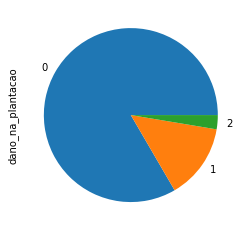

In [7]:
data['dano_na_plantacao'].value_counts().plot.pie()

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.1, random_state = 42)

In [10]:
y_train.unique()

array([2, 0, 1])

<AxesSubplot:ylabel='dano_na_plantacao'>

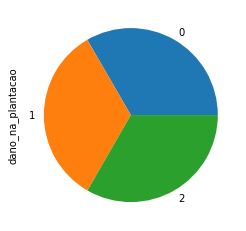

In [11]:
y_train.value_counts().plot.pie()

## **Construção do modelo** <a class="anchor" id="model_cons"></a>

[Voltar para o índice](#index)

Aqui, o modelo é construido através da combinação dos classificadores `KNeighborsClassifier` e `RandomForestClassifier` com o critério de voto sendo *`soft`*. 

In [12]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

knn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier()

vot_clf = VotingClassifier(estimators=
                           [('KNN', knn_clf),
                            ('rf', rf_clf),],
                           voting = 'soft'
                          )

In [13]:
vot_clf.fit(X_train, y_train)

pred_train = vot_clf.predict(X_train)
pred_test = vot_clf.predict(X_test)

(accuracy_score(y_train, pred_train), accuracy_score(y_test, pred_test))

(0.9596131747097978, 0.8507119660254809)

In [14]:
cm_train, cm_test = (confusion_matrix(y_train, pred_train), (confusion_matrix(y_test, pred_test)))

In [15]:
(cm_train/cm_train.sum().sum()).round(2)

array([[0.31, 0.02, 0.01],
       [0.  , 0.32, 0.01],
       [0.  , 0.  , 0.33]])

In [16]:
(cm_test/cm_test.sum().sum()).round(2)

array([[0.26, 0.05, 0.02],
       [0.02, 0.28, 0.03],
       [0.  , 0.02, 0.31]])

Assim, a acurácia do *test-set* está pouco abaixo do que é obtido com a previsão sobre o *training-set*, indicando que não está ocorrendo *overfitting*. Logo, os valores que forem tratados na base de [`Safra_2020.csv`](Safra_2020.csv) terão como uma acurácia aproximada de $85,12\%$.

## **Previsão sobre os dados de 2020** <a class="anchor" id="model_pred"></a>

[Voltar para o índice](#index)

In [17]:
data_2020_df = pd.read_csv('Safra_2020.csv', index_col = 0)
data_2020 = full_transform(data_2020_df, train_set=False)

data_2020.head()

,Estimativa_de_Insetos,Semanas_Utilizando,Semanas_Sem_Uso,Dose_Total,Categoria_Pesticida_1,Categoria_Pesticida_2,Categoria_Pesticida_3,Tipo_de_Solo_Cultivo_0,Tipo_de_Solo_Cultivo_1,Tipo_de_Solo_Cultivo_2,Tipo_de_Solo_Cultivo_3
Identificador_Agricultor,,,,,,,,,,,
SCROP80001,-1.346281,-1.498407,-0.097412,-0.643209,0.0,1.0,0.0,0.0,0.0,1.0,0.0
SCROP80002,-1.314224,-2.023497,-0.402029,-1.272683,0.0,1.0,0.0,0.0,0.0,1.0,0.0
SCROP80003,-1.314224,-1.148346,-0.503568,-0.922975,0.0,1.0,0.0,0.0,0.0,1.0,0.0
SCROP80004,-1.314224,-0.098165,-0.300490,-0.608238,0.0,1.0,0.0,0.0,0.0,1.0,0.0
SCROP80005,-1.314224,-0.798286,-0.808186,-0.818063,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [18]:
X_2020 = data_2020.to_numpy()
pred_2020 = pd.DataFrame(vot_clf.predict(X_2020),
                         columns=['dano_na_plantacao'], 
                         index = data_2020.index
                        )

In [19]:
pred_2020

,dano_na_plantacao
Identificador_Agricultor,
SCROP80001,0
SCROP80002,0
SCROP80003,0
SCROP80004,1
SCROP80005,0
...,...
SCROP88854,0
SCROP88855,1
SCROP88856,1


In [20]:
pred_2020.to_csv('previsão_2020.csv')

## Informações sobre os dados obtidos

In [21]:
data_2020_df.index = data_2020_df['Identificador_Agricultor']
data_2020_df.drop('Identificador_Agricultor', inplace=True, axis = 1)
data_2020 = pd.concat([data_2020_df, pred_2020], axis = 1)
data_2020.head()

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,Tipo_de_Solo_Cultivo,Dose_Total,dano_na_plantacao
Identificador_Agricultor,,,,,,,,,,,
SCROP80001,256,0,1,2,35,11.0,9,1,2.0,385.0,0
SCROP80002,283,0,1,2,5,5.0,6,1,2.0,25.0,0
SCROP80003,283,0,1,2,15,15.0,5,2,2.0,225.0,0
SCROP80004,283,0,1,2,15,27.0,7,2,2.0,405.0,1
SCROP80005,283,0,1,2,15,19.0,2,1,2.0,285.0,0


É possível verificar que ocorre um aumento dos valores de danos que são causados aos plantios no ano de 2020. Aproximadamente $29\%$ sofrem danos causados por outros motivos, enquanto $12\%$ sofrem danos causados por pesticidas.

<AxesSubplot:ylabel='dano_na_plantacao'>

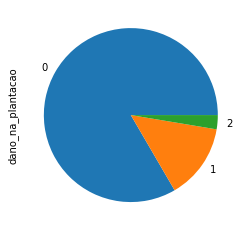

In [22]:
y.value_counts().plot.pie()

In [23]:
(round(100*y[y==1].value_counts().sum()/y.value_counts().sum(), 2),
 round(100*y[y==2].value_counts().sum()/y.value_counts().sum(), 2))

(13.98, 2.63)

<AxesSubplot:ylabel='dano_na_plantacao'>

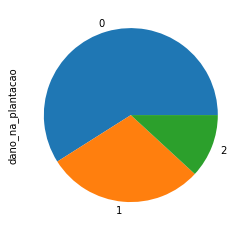

In [24]:
data_2020['dano_na_plantacao'].value_counts().plot.pie()

In [25]:
(round(100*data_2020[data_2020['dano_na_plantacao']==1].value_counts().sum()/data_2020['dano_na_plantacao'].value_counts().sum(), 2),
 round(100*data_2020[data_2020['dano_na_plantacao']==2].value_counts().sum()/data_2020['dano_na_plantacao'].value_counts().sum(), 2))

(29.18, 11.84)

In [26]:
num_feats = ['Estimativa_de_Insetos', 'Semanas_Utilizando', 'Semanas_Sem_Uso', 'Dose_Total', 'dano_na_plantacao']
cat_feats = ['Categoria_Pesticida', 'Tipo_de_Solo_Cultivo', 'dano_na_plantacao']

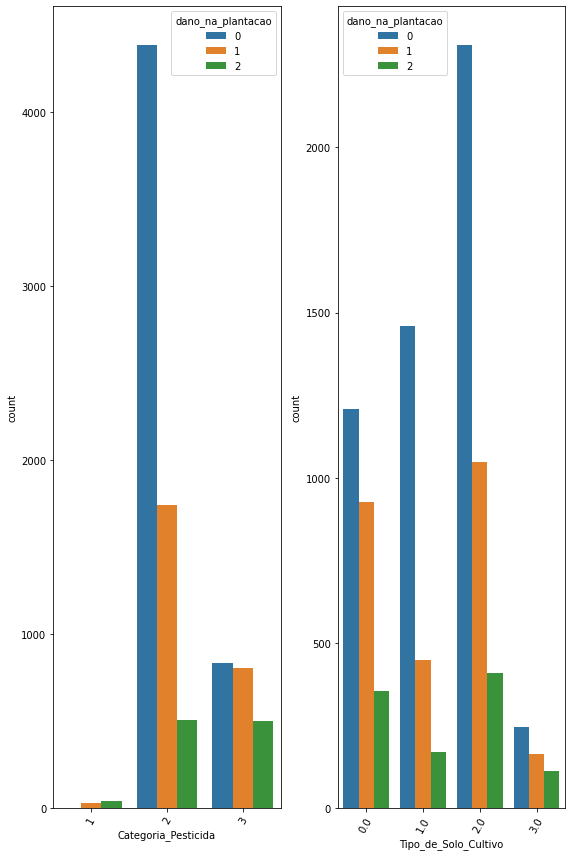

In [27]:
hist_stack_plot(data_2020, cat_feats[:-1], stack_target='dano_na_plantacao')

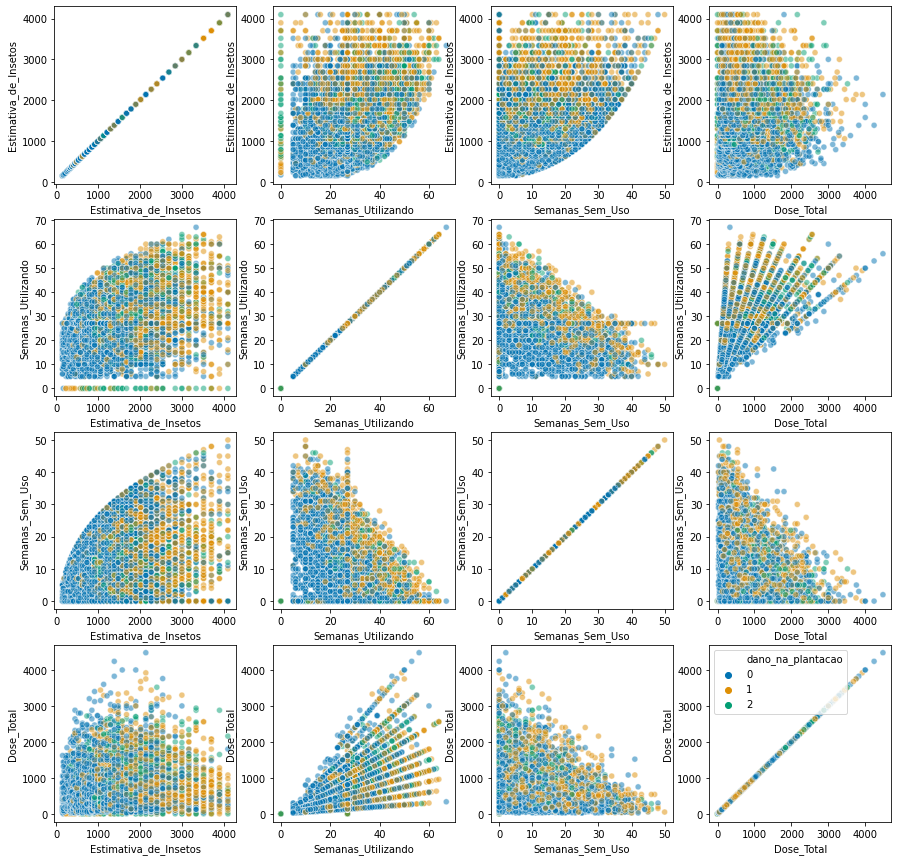

In [28]:
scatter_plot_num(data_2020, num_feats[:-1], stack_target = 'dano_na_plantacao', alpha = 0.5)

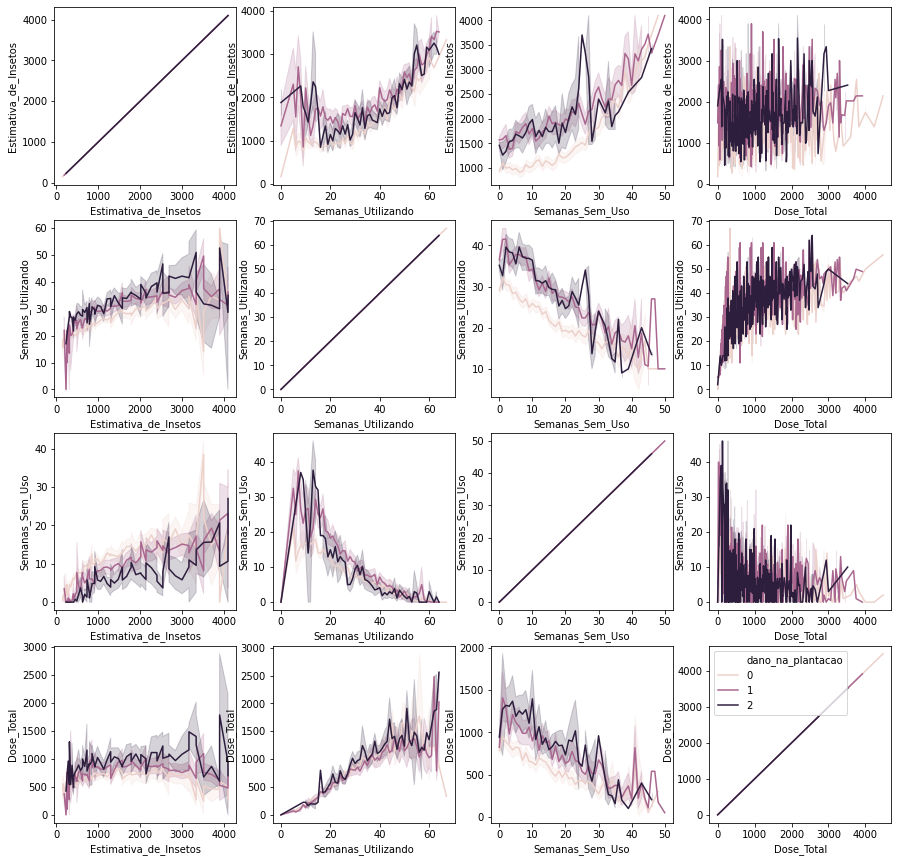

In [29]:
rel_plot_num(data_2020, num_feats[:-1], hue = 'dano_na_plantacao')

O aumento da quantidade de danos causados se deve às tendências que podem ser observadas dos gráficos acima. Nelas, é possível observar uma assinatura mais forte dos parâmetros que possuem correlação com tais danos quando comparado aos gráficos dos anos anteriores.